In [9]:
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score, precision_recall_curve
from scipy.stats import uniform, randint

# Ensure plots are displayed within the notebook
%matplotlib inline


In [10]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=column_names)


In [11]:
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
# print("Analysing Original Data Distribution")
# print("------------------------------------")

# # Check for missing values
# print("Null values in features")
# print(data.isnull().sum())

# # Visualize data distribution
# sns.pairplot(data, hue='Outcome')
# plt.show()


In [13]:
# Separate features and target
X = data.drop('Outcome', axis=1)    # what does axis do?
y = data['Outcome']

# Apply SMOTE
X_resampled, y_resampled = SMOTE(random_state=123).fit_resample(X, y)    # what is random state?

# Normalize features
X_scaled = StandardScaler().fit_transform(X_resampled)

# Check original class distribution
print("Original class distribution:")
print(y.value_counts())
print()

# Check new class distribution
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())
print()

# Verify the number of rows before and after SMOTE
print(f"Number of rows before SMOTE: {X.shape[0]}")
print(f"Number of rows after SMOTE: {X_resampled.shape[0]}")


Original class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Class distribution after SMOTE:
Outcome
1    500
0    500
Name: count, dtype: int64

Number of rows before SMOTE: 768
Number of rows after SMOTE: 1000


In [14]:
# def detect_outliers_z_score(feature, threshold=3):    # outputs a list of values which are outliers for that feature
#     z_scores = np.abs((feature - feature.mean()) / feature.std())
#     outliers = np.where(z_scores > threshold)    # how does it store the actual value instead of normalized in the outliers list?
#     return outliers

# # Detect outliers for each feature using Z-score
# z_score_outliers = {}
# for column in X.columns:
#     outliers = detect_outliers_z_score(X[column])
#     z_score_outliers[column] = outliers[0]

# # Display the outliers
# for column, outliers in z_score_outliers.items():
#     print(f"Outliers in {column}: {outliers}")

# def detect_outliers_iqr(data, threshold=1.5):
#     Q1 = data.quantile(0.25)
#     Q3 = data.quantile(0.75)
#     IQR = Q3 - Q1
#     outliers = data[((data < (Q1 - threshold * IQR)) | (data > (Q3 + threshold * IQR)))]    # What logic?
#     return outliers

# # Detect outliers for each feature using IQR
# iqr_outliers = {}
# for column in X.columns:
#     outliers = detect_outliers_iqr(X[column])
#     iqr_outliers[column] = outliers

# # Display the outliers
# for column, outliers in iqr_outliers.items():
#     print(f"Outliers in {column}: {outliers.index.tolist()}")    # why so much processing needed?

In [15]:
# Spliting Data into Training and Testing sets using Stratify 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.20, random_state = 42, stratify=y_resampled)

Model training time: 0.28 seconds
Confusion Matrix
[[76 24]
 [18 82]]
Accuracy: 0.790
Precision: 0.791
Recall: 0.790
F1-score: 0.790
CV Results =  77.8 % +/- 6.27375485654325 %


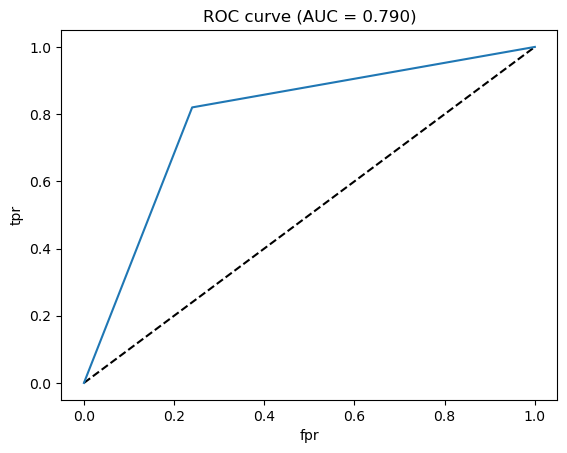

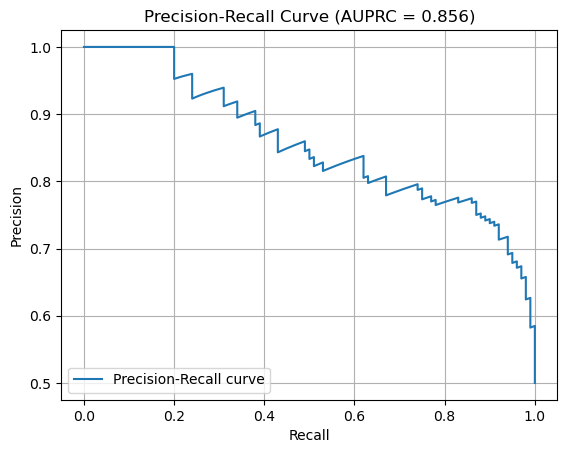

In [14]:
# XGBost with metrics
xg_class = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=8,
    subsample=0.6,
    reg_alpha=0.005,
    seed=27
)

# Train the model and Calculating running time without idle time
training_time = timeit.timeit(lambda: xg_class.fit(X_train, y_train), number=1)

# Make predictions
y_pred = xg_class.predict(X_test)

# calculate metrics of predictions
print(f"Model training time: {training_time:.2f} seconds")
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

# print(classification_report(y_test, y_pred))
# Assuming y_pred contains probabilities, convert them to binary labels
# y_pred_binary = (y_pred >= 0.5).astype(int)
#Substitute y_pred with y_pred_binary if predicted values are not binary 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(f1))

# Score/Accuracy if Cross Validation
skfold = StratifiedKFold(n_splits=10)
cv_score = cross_val_score(xg_class,X_scaled,y_resampled,cv=skfold)
print("CV Results = ", (np.mean(cv_score) *100),"% +/-",(np.std(cv_score)*100), "%")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.figure(figsize=(8, 6))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='XGBoost')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve (AUC = {:.3f})'.format(roc_auc_score(y_test, y_pred)))
plt.show()

# Plot precision-recall curve
y_probs = xg_class.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPRC = {:.3f})'.format(auc(recall, precision)))
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


C:\Users\Priyansh\miniconda3\envs\ML-Summer\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Priyansh\miniconda3\envs\ML-Summer\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Priyansh\miniconda3\envs\ML-Summer\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Priyansh\miniconda3\envs\ML-Summer\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Best parameters found:  {'estimator': DecisionTreeClassifier(), 'learning_rate': 0.0001, 'n_estimators': 50}
Best cross-validation score:  0.771
CV Results =  75.39999999999999 % +/- 5.7306195127577615 %
Model training + tuning time: 0.01 seconds
Confusion Matrix
[[80 20]
 [15 85]]
Accuracy: 0.825
Precision: 0.826
Recall: 0.825
F1-score: 0.825


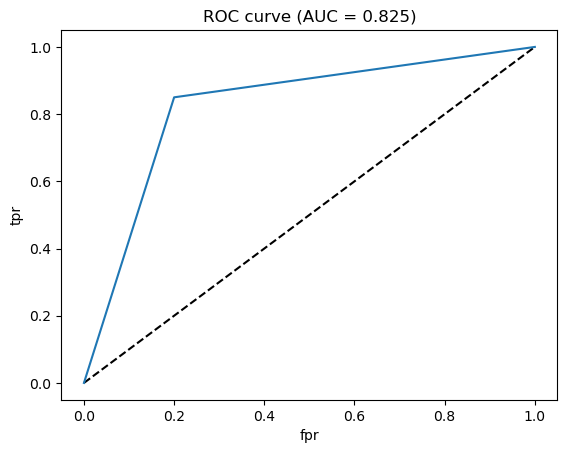

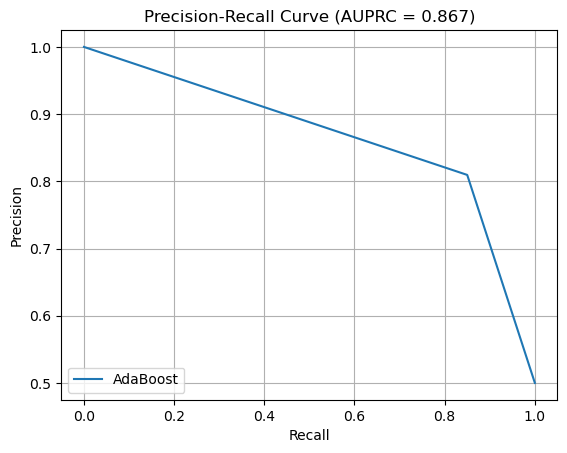

In [8]:
# AdaBoost with metrics
# Define the base estimator
base = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'estimator': [base],
    'n_estimators': [50, 100, 150]
}

# Initialize the AdaBoost classifier and Set up the grid search 
ada = AdaBoostClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=cv, n_jobs=-1)

# Fit the model for all sets of hyperparameters and Calculate running time including hyperparameter tuning
tuning_time = timeit.timeit(lambda: grid_search.fit(X_scaled, y_resampled), number=1)

# Make predictions with the best model
ada_best = grid_search.best_estimator_
training_time = timeit.timeit(lambda: ada_best.fit(X_train, y_train), number=1)
y_pred = ada_best.predict(X_test)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Score/Accuracy if Cross Validation
skfold = StratifiedKFold(n_splits=10)
cv_score = cross_val_score(ada_best,X_scaled,y_resampled,cv=skfold)
print("CV Results = ", (np.mean(cv_score) *100),"% +/-",(np.std(cv_score)*100), "%")

# calculate metrics of predictions
print(f"Model training + tuning time: {training_time:.2f} seconds")
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(f1))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.figure(figsize=(8, 6))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='AdaBoost')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve (AUC = {:.3f})'.format(roc_auc_score(y_test, y_pred)))
plt.show()

# Plot precision-recall curve
y_probs = ada_best.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='AdaBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPRC = {:.3f})'.format(auc(recall, precision)))
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


Best Hyperparameters: {'criterion': 'squared_error', 'learning_rate': 0.1554543991712842, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 29, 'n_estimators': 751, 'subsample': 0.7301321323053057}
Best Cross-validation Score: 0.8150000000000001
Cross-validation Score: 81.3 +/- 3.287856444554718 %
Precision: 0.8157894736842105
Recall: 0.815
F1-score: 0.8148843026891808
AUPRC: 0.8877211423285596
ROC AUC: 0.8931


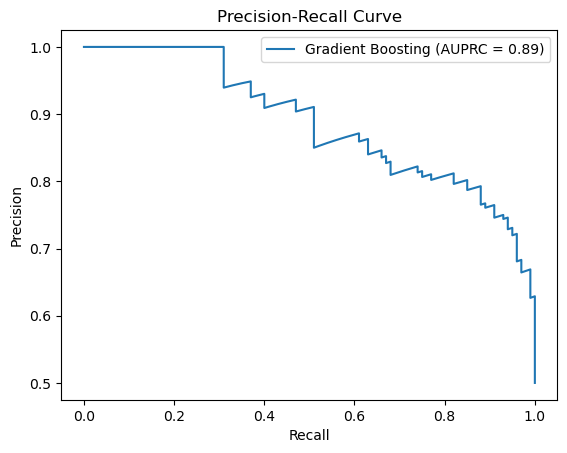

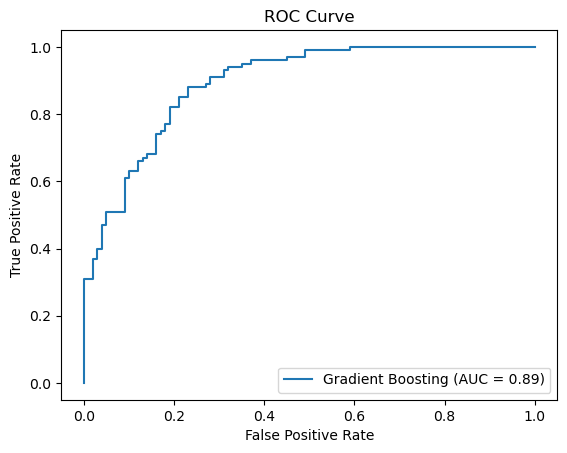

In [39]:

# Gradient Boosting
model = GradientBoostingClassifier(random_state=23)

# Define the parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(50, 1000),
    'min_samples_split': randint(2, 32),
    'min_samples_leaf': randint(1, 16),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['friedman_mse', 'squared_error']
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-validation Score:", random_search.best_score_)

# Evaluate the model using K-fold cross-validation with the best hyperparameters
best_model = random_search.best_estimator_
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Score:", (cv_scores.mean() *100), "+/-", (cv_scores.std()*100), "%")

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'Gradient Boosting (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


Best Hyperparameters: {'depth': 4, 'iterations': 3000, 'l2_leaf_reg': 1.0, 'learning_rate': 0.004, 'min_data_in_leaf': 1}
Best Cross-validation Score: 0.7987499999999998
Cross-validation Score: 79.3 +/- 3.8483762809787714 %
Precision: 0.796452617827354
Recall: 0.795
F1-score: 0.7947485669945684
AUPRC: 0.8470387255637278
ROC AUC: 0.8718999999999999


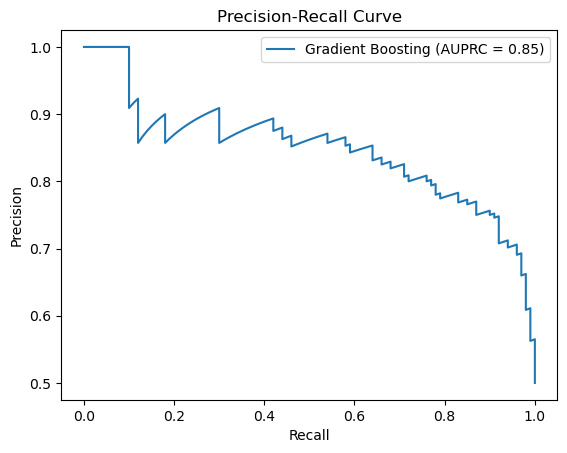

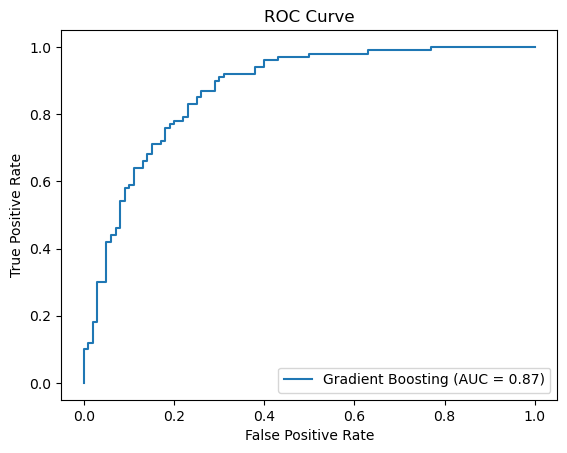

In [16]:
# CatBoost with metrics
model = CatBoostClassifier(random_state=42, silent=True)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.010, 0.004],
    'depth': [4],
    'l2_leaf_reg': [1.0],
    'min_data_in_leaf': [1, 4, 8, 16, 32],
    'iterations': [3000]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1,error_score='raise')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Evaluate the model using K-fold cross-validation with the best hyperparameters
best_model = grid_search.best_estimator_
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Score:", (cv_scores.mean() *100), "+/-", (cv_scores.std()*100), "%")

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'Gradient Boosting (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Hyperparameters: {'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.01, 'min_child_samples': 1, 'min_child_weight': 0.01, 'n_estimators': 1500, 'num_leaves': 11, 'reg_lambda': 1.0}
Best Cross-validation Score: 0.8012499999999999
[LightGBM] [Info] Number of positive: 450, number of negative: 450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set:

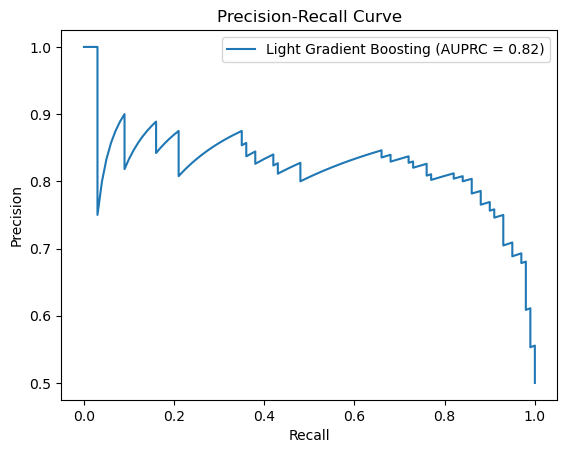

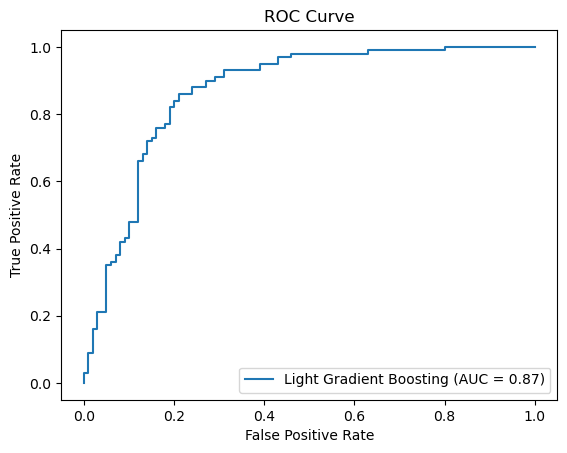

In [17]:
# LGBM with metrics
model = LGBMClassifier(random_state=124, n_jobs=6)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.010, 0.004],
    'num_leaves': [11],
    'reg_lambda': [1.0],
    'min_child_samples': [1, 4, 8, 16, 32],
    'min_child_weight': [0.01],
    'n_estimators': [1500],
    'boosting_type': ['gbdt'],
    'class_weight': [None, 'balanced']
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Evaluate the model using K-fold cross-validation with the best hyperparameters
best_model = grid_search.best_estimator_
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Score:", (cv_scores.mean() *100), "+/-", (cv_scores.std()*100), "%")

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'Light Gradient Boosting (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'Light Gradient Boosting (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()